In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt

In [5]:
class KleibersLawDataset(Dataset):
    def __init__(self, path):
        self.data = np.loadtxt(path,delimiter=",")
        self.x = torch.from_numpy(np.log(self.data[:-1,:]))
        self.y = torch.from_numpy(np.log(self.data[-1:,:]))

    def __len__(self):
        return (len(self.x))

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

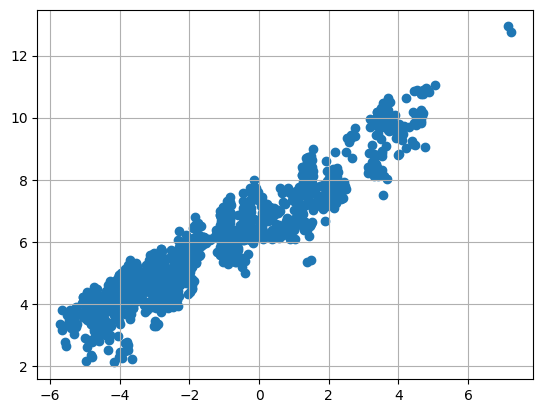

In [9]:
training_data = KleibersLawDataset("./datasets/kleibers_law_data.csv")
train_dataloader = DataLoader(training_data)

xdata = train_dataloader.dataset.x
ydata = train_dataloader.dataset.y
xdata.numpy()
ydata.numpy()

fig, ax = plt.subplots()
ax.scatter(xdata.flatten(),ydata.flatten())
ax.grid()
plt.show()